In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def PrintArrayInfo(a): 
    print("Array info:") 
    print("shape:", a.shape) 
    print("dtype:", a.dtype) 
    print("min, max:", a.min(), a.max()) 

In [3]:
# This represents an internal tile object of our map
class Tile:
    elevation = 0
    is_water = False
    

# Part I. Generating Terrain with perlin noise

In [4]:
# Credits to the following stack overflow answer: 
# https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy
def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here

def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y


Array info:
shape: (1000, 1000)
dtype: float64
min, max: -0.5 0.53527540625


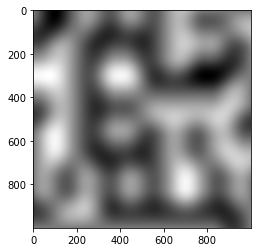

In [5]:
height = 1000
width = 1000
resolution = 5

liny = np.linspace(0, resolution, height, endpoint=False)
linx = np.linspace(0, resolution, width, endpoint=False)
x, y = np.meshgrid(linx, liny)  # FIX3: I thought I had to invert x and y here but it was a mistake
terrain_elevations = perlin(x, y, seed=14)
plt.imshow(terrain_elevations, cmap='gray')
PrintArrayInfo(terrain_elevations)

Since we have a way to generate simple perlin noise, we can generate smooth terrain where the value of the noise determines land elevation, with elevation below a certain threshold represents water:

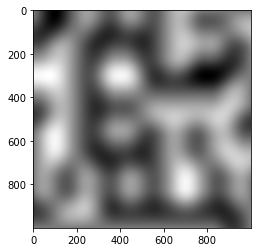

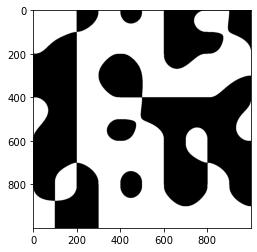

In [6]:
#now we check if the elevation value is below sea level.
sea_level = 0.0
def IsTileWater(value, sea_level):
    is_water = True if (value < sea_level) else False
    return is_water
CheckWater = np.vectorize(IsTileWater)

terrain_is_water = CheckWater(terrain_elevations, sea_level)
plt.imshow(terrain_elevations, cmap='gray')
plt.show()
plt.imshow(terrain_is_water, cmap='gray')
plt.show()

The above image looks too uniform and smooth.
We need to add more detail to the terrain.
In order to do that we can introduce multiple octaves of noise and control how detailed these octaves are with the use of a lacunarity and persistance variables that determine the frequence and amplitude change of each subsequent octave.

Note: persistance should be kept between 0 and 1, and lacunarity should be above 1, since lacunarity should increase frequency values, and persistance should decrease amplitude values as number of octaves increases.

In [7]:
def GeneratePerlinMap(w, h, res, seed=14, octaves=3, persistance=1, lacunarity=1):
        
        
    liny = np.linspace(0, res, h, endpoint=False)
    linx = np.linspace(0, res, w, endpoint=False)
    x, y = np.meshgrid(linx, liny)  # FIX3: I thought I had to invert x and y here but it was a mistake
    terrain_elevations = np.zeros((w, h))
    amplitude = 1.0
    frequency = 1.0
    
    for i in range(octaves):
        s = 14
        if type(seed) == type([]):
            s = seed[i]
        elif type(seed) == type(14):
            s = seed
        terrain_elevations += perlin(x * frequency, y * frequency, s) * amplitude
        amplitude *= persistance
        frequency *= lacunarity
    
    return terrain_elevations

Using this approach, we can see that setting lacunarity and persistance both to 1 leaves the terrain unchanged

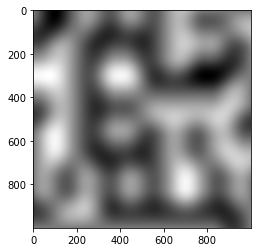

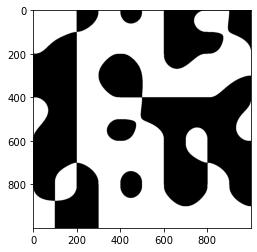

In [8]:
lacunarity = 1
persistance = 1
sea_level = 0

height = 1000
width = 1000
resolution = 5

terrain_elev = GeneratePerlinMap(width, height, resolution, seed=14, octaves=3, persistance=persistance, lacunarity=lacunarity)
terrain_is_w = CheckWater(terrain_elev, sea_level)

plt.imshow(terrain_elev, cmap='gray')
plt.show()
plt.imshow(terrain_is_w, cmap='gray')
plt.show()

However, if we set persistance to 0.5 and lacunarity to 1.5 , we can see the terrain becomes alot less uniform looking, and more realistic:

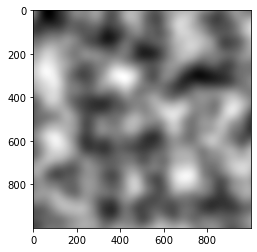

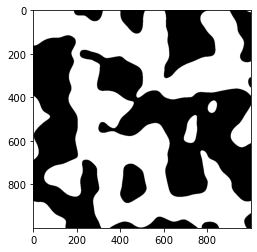

In [9]:
lacunarity = 1.5
persistance = 0.5
sea_level = 0

terrain_elev = GeneratePerlinMap(width, height, resolution, seed=14, octaves=3, persistance=persistance, lacunarity=lacunarity)
terrain_is_w = CheckWater(terrain_elev, sea_level)

plt.imshow(terrain_elev, cmap='gray')
plt.show()
plt.imshow(terrain_is_w, cmap='gray')
plt.show()

Further, increasing the number of octaves increases detail, and we start seeing more and more realistic landshapes:

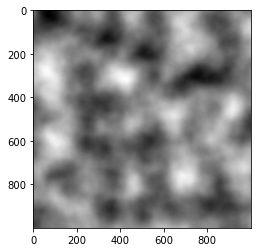

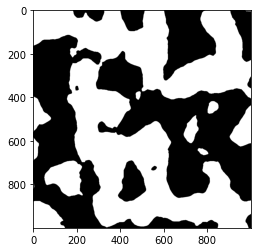

In [10]:
lacunarity = 1.5
persistance = 0.5
octaves = 10
sea_level = 0

terrain_elev = GeneratePerlinMap(width, height, resolution, seed=14, octaves=10, persistance=persistance, lacunarity=lacunarity)
terrain_is_w = CheckWater(terrain_elev, sea_level)

plt.imshow(terrain_elev, cmap='gray')
plt.show()
plt.imshow(terrain_is_w, cmap='gray')
plt.show()

We can also set different seeds for each octave to further randomize the landscape, as well as change the sea level to make the landscape have more or less water (shown in white in the second image). As we can see below, lowering the sea_level makes the map look less like a set of islands within a larger ocean, and instead makes it look like a set of lakes within a larger landmass.

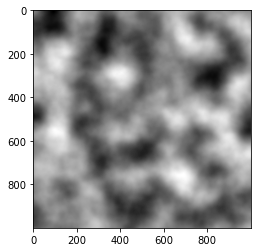

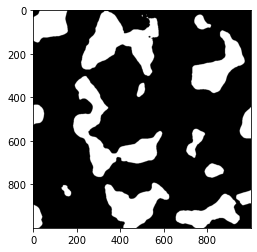

In [11]:
lacunarity = 1.5
persistance = 0.5
octaves = 10
sea_level = -0.2

terrain_elev = GeneratePerlinMap(width, height, resolution, seed=[14, 123, 15, 1518, 1881, 101983, 181779, 188902, 788, 917], octaves=10, persistance=persistance, lacunarity=lacunarity)
terrain_is_w = CheckWater(terrain_elev, sea_level)

plt.imshow(terrain_elev, cmap='gray')
plt.show()
plt.imshow(terrain_is_w, cmap='gray')
plt.show()

Since we want to generate biomes and have nations spread across a singular landmass (since it would provoke more interactions between them) we want to use a lower sea level. We can play with lacunarity and pesistance values to generate a good looking terrain.

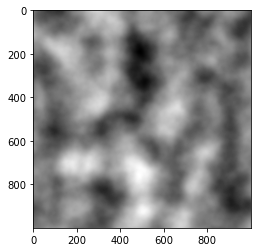

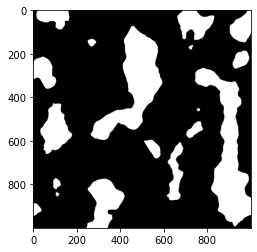

In [12]:
lacunarity = 1.5
persistance = 0.5
octaves = 10
sea_level = -0.2
width = 1000
height = 1000
resolution = 5

seeds = list((np.random.rand(octaves) * 1000).astype(int))


terrain_elev = GeneratePerlinMap(width, height, resolution, seed=seeds, octaves=octaves, persistance=persistance, lacunarity=lacunarity)
terrain_is_w = CheckWater(terrain_elev, sea_level)

plt.imshow(terrain_elev, cmap='gray')
plt.show()
plt.imshow(terrain_is_w, cmap='gray')
plt.show()

It already looks much better than the original, simple perlin noise terrain. Now the next step is generating biomes/dryness.

# Part II. Generating Biomes with voronoi diagrams

Now, we can introduce voronoi diagrams and set the pixels to be different colors depending on the biome we are in. 

**First, we get a sample of origin coordinates:**

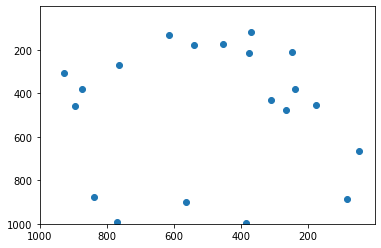

In [13]:
def voronoi_heuristic(x1, y1, x2, y2):
    return abs(x1-x2) + abs(y1-y2)
    
def voronoi(width, height, num_points = 20):
    cell_origins_x = np.zeros(num_points)
    cell_origins_y = np.zeros(num_points)
    
    for point in range(num_points):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        cell_origins_x[point] = x
        cell_origins_y[point] = y
    return (cell_origins_x, cell_origins_y)

origins = voronoi(width, height, 20)

plt.ylim(height)
plt.xlim(width)
plt.scatter(origins[0], origins[1])

**Now we can generate the voronoi diagram around these points:**

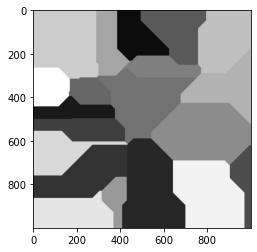

In [14]:
def region_to_color(n, num_regions):
    n += 1
    return [int(255 * (n / num_regions)), int(255 * (n / num_regions)), int(255 * (n / num_regions))]
    

def voronoi_iter(width, height, origins, heuristic):
    num_points=len(origins[0])
    voronoi_img = 255 * np.ones([height,width,3],dtype='uint8')
    voronoi_biome_data = np.ones([height,width,1],dtype='uint8')
    voronoi_hist = []
    for x in range(width):
        for y in range(height):
            closest_point = 0 #default is the first origin point.
            closest_distance = width*height
            for i in range(num_points):
                dist = heuristic(origins[0][i], origins[1][i], x, y)
                #print(i)
                if dist < closest_distance:
                    closest_distance = dist
                    closest_point = i
            
            voronoi_img[x, y] = region_to_color(closest_point, num_points)
            voronoi_biome_data[x, y] = closest_point
            voronoi_hist.append(closest_point)
    return voronoi_img, voronoi_hist, voronoi_biome_data



voronoi_img, hist, terrain_biomes = voronoi_iter(1000, 1000, origins, voronoi_heuristic)
plt.imshow(voronoi_img)
plt.show()

Below is a histogram of the biomes we have on our map:

In [15]:
plt.hist(hist, 20) 
plt.show()

We can also change the heuristic of our voronoi diagram to get a different result in our biome shapes:

In [16]:
def voronoi_heuristic_2(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2) ** 0.5
#voronoi_img, hist, terrain_biomes = voronoi_iter(1000, 1000, origins, voronoi_heuristic_2)
#plt.imshow(voronoi_img)
#plt.show()

Changing the heuristic from manhattan distance to eucledian distance produces sharper, and more crystal-like shapes.

In my opinion, the manhattan distance heuristic makes the diagram look better, so we will stick to manhattan distance for not, but towards the end, we will change it to eucledian distance since it looks better when overlayed over terrain.

Since we know which parts of our map are water, and which are land, and biomes should be limited to land areas, we can mask terrain_biomes with our terrain_is_w in order to only display the biomes over the water:

# Part III. Random walks to simulate spread

We can now create random walks at a sampled set of points (similar to what we did with voronoi diagrams) in order to represents the spread of individual nations.

First we generate 100x100 test datasets for elevation, water, and biomes

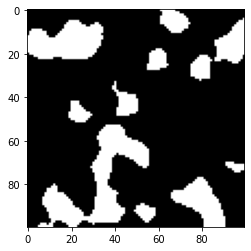

In [17]:
###############################################
# Elevations and water:
###############################################
lacunarity = 1.5
persistance = 0.5
octaves = 10
sea_level = -0.2
width = 100
height = 100
resolution = 4

seeds = list((np.random.rand(octaves) * 1000).astype(int))


test_elevations = GeneratePerlinMap(width, height, resolution, seed=seeds, octaves=octaves, persistance=persistance, lacunarity=lacunarity)
test_is_water = CheckWater(test_elevations, sea_level)
plt.imshow(test_elevations, cmap='gray')
plt.show()
plt.imshow(test_is_water, cmap='gray')
plt.show()

###############################################
# Biomes:
###############################################
num_biomes = 5
origins = voronoi(width, height, num_biomes)
test_voronoi_img, test_hist, test_biomes = voronoi_iter(width, height, origins, voronoi_heuristic)
plt.imshow(test_voronoi_img)
plt.show()

In [18]:
import random

class Particle:
    #base inputs
    def __init__(self, nation, x, y, lifetime, biome_bias, elevation_bias):
        self.nation = nation # must be an integer > 0. value of 0 means empty nation.
        self.x = x
        self.y = y
        self.lifetime = lifetime
        
        # this is a list with n biases. n is the number of biomes on the map.
        # bias must be 0 or positive
        # bias 0 makes biome not affect lifetime. bias 1 makes biome take away 1 lifetime per step.
        self.biome_bias = biome_bias
        
        # an integer > 0
        # higher values yield more elevation bias based
        self.elevation_bias = elevation_bias
        
# returns particle's lifetime.
# If return value is 0, then the walk is done
def walk_particle(rand_func, particle, elevations, is_water, biome_map, nations, width, height):
    if particle.lifetime == 0:
        return 0
    old_x = particle.x
    old_y = particle.y
    direction = rand_func(0, 3)
    #print(direction)
    if direction == 0:
        particle.x+=1
    elif direction == 1:
        particle.x-=1
    elif direction == 2:
        particle.y+=1
    elif direction == 3:
        particle.y-=1
    
    x = particle.x
    y = particle.y
    
    #print(type(x))
    
    if (x < 0 or x >= width or y < 0 or y >= height or is_water[y, x] == True): # maybe need to change order of x, y
        particle.x = old_x
        particle.y = old_y
        return particle.lifetime
    
    
    nations[old_y, old_x] = particle.nation
    
    # calculate lifetime loss:
    old_elev = elevations[old_y, old_x]
    new_elev = elevations[x,y]
    elevation_loss = particle.elevation_bias * abs(old_elev - new_elev)
    biome_index = biome_map[y, x][0]
    biome_loss = particle.biome_bias[biome_index]
    lifetime_loss = biome_loss + elevation_loss
    
    particle.lifetime-=lifetime_loss
    return particle.lifetime

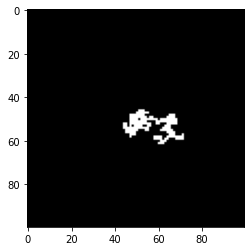

In [19]:
# these biases make the particle lifetime decrease by about 1 unit every step
part = Particle(1, 50, 50, 500, [1, 1, 1, 1, 1], 1) 

xs = []
ys = []

test_nations = np.zeros((width, height))

while part.lifetime > 0:
    lf = walk_particle(random.randint, part, test_elevations, test_is_water, test_biomes, test_nations, 100, 100)
    xs.append(part.x)
    ys.append(part.y)
    #print(lf)

plt.imshow(test_nations, cmap='gray')

Now that we have a single particle working, we can add more walks in order to form a whole country.

In [20]:
# Seed countries.
def nation_origins(width, height, is_water, num_points = 5):
    cell_origins_x = np.zeros(num_points)
    cell_origins_y = np.zeros(num_points)
    
    for point in range(num_points):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        if is_water[y, x]: continue
        cell_origins_x[point] = int(x)
        cell_origins_y[point] = int(y)
    return (cell_origins_x, cell_origins_y)

class Nation:
    def __init__(self, x, y, nation_number, biome_bias, elevation_bias, randomize_function):
        self.x = int(x)
        self.y = int(y)
        self.nation_number = nation_number
        self.biome_bias = biome_bias
        self.elevation_bias = elevation_bias
        self.random = randomize_function # This function must take no args and return a number between 0 and 3 inclusive.
        # 0 = +x
        # 1 = -x
        # 2 = +y
        # 3 = -y
        self.particles = []
    def init_particles(self, num_particles, start_lifetime):
        for p in range(num_particles):
            part = Particle(self.nation_number, self.x, self.y, start_lifetime, self.biome_bias, self.elevation_bias) 
            self.particles.append(part)
            
            
def walk_particles_once(nation, width, height, elevations, is_water, biomes, nations_data):
    #print(self.nation_number)
    for part in nation.particles:
        if part.lifetime > 0:
            walk_particle(nation.random, part, elevations, is_water, biomes, nations_data, width, height)

In [21]:
num_nations = 10
iterations = 10000

nations = []
nation_xs, nation_ys = nation_origins(width, height, test_is_water, num_nations)

for i in range(num_nations):
    nation = Nation(nation_xs[i], nation_ys[i], i, [1, 1, 1, 1, 1], 1, random.randint)
    nation.init_particles(30, 500)
    nations.append(nation)
    
nations_data = np.zeros((width, height))

for i in range(iterations):
    for nation in nations:
        walk_particles_once(nation, width, height, test_elevations, test_is_water, test_biomes, nations_data)

In [22]:
plt.imshow(nations_data, cmap='gray')

We now have proper nation spread. Now we have to put together our datasets in order to produce a cohesive image.

# Part IV. Combining data into the final image.

-0.6370610361003249 [-0.31482441444013, -0.1, 0, 0.18562207583422405, 0.3712441516684481, 0.5568662275026721] 0.6960827843783401


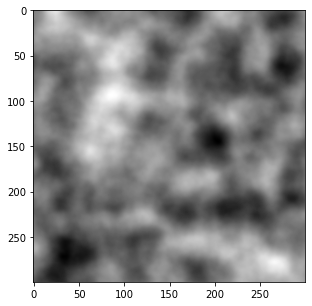

In [23]:
#initialization

width = 300
height = 300
image = 255 * np.ones([width, height,3],dtype='uint8')



lacunarity = 1.5
persistance = 0.5
octaves = 10
sea_level = -0.1
resolution = 5

seeds = list((np.random.rand(octaves) * 1000).astype(int))


elevations = GeneratePerlinMap(width, height, resolution, seed=seeds, octaves=octaves, persistance=persistance, lacunarity=lacunarity)
is_water = CheckWater(elevations, sea_level)


#color the image based on the elevation:
terrain_colors = [[3, 94, 168], [2, 123, 222], [238, 195, 123], [107, 170, 74], [70, 136, 35], [39, 95, 9], [213, 214, 213]] 
#deepwater, shallowwater, beach, ground, highground, higher ground, mountaintops.
min_elev = elevations.min()
max_elev = elevations.max()

#elevation cutoffs:
cut_water_shallow = sea_level
cut_water_deep = sea_level - ((sea_level - min_elev) * 0.4)
cut_ground_higher = max_elev - (max_elev / 5)
cut_ground_high = 2 * cut_ground_higher / 3
cut_ground = cut_ground_higher / 3
cut_beach = 0
elevation_cutoff = [cut_water_deep, cut_water_shallow, cut_beach, cut_ground, cut_ground_high, cut_ground_higher] #highest points of: deepwater, water, beach, ground, highground, higherground. Mountaintops are max elev

for y in range(height):
    for x in range(width):
        elev = elevations[y, x]
        ec = elevation_cutoff
        if elev < ec[0]:
            image[y, x] = terrain_colors[0] #deepwater
        elif elev < ec[1]:
            image[y, x] = terrain_colors[1] #shallow water
        elif elev < ec[2]:
            image[y, x] = terrain_colors[2] #beach
        elif elev < ec[3]:
            image[y, x] = terrain_colors[3] #ground
        elif elev < ec[4]:
            image[y, x] = terrain_colors[4] #highground
        elif elev < ec[5]:
            image[y, x] = terrain_colors[5] #higherground
        else:
            image[y, x] = terrain_colors[6] #mountaintops

print(min_elev, elevation_cutoff, max_elev)
plt.figure(figsize = (5,5))
plt.imshow(elevations, cmap='gray')
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(is_water, cmap='gray')
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(image)
plt.show()




Above we can see the heightmap, the water map, and the colorized terrain texture map.

Now, we can generate a voronoi of biomes.

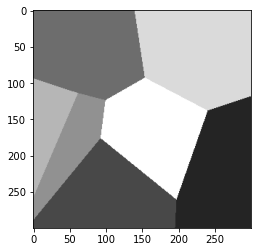

In [24]:
num_biomes = 7
origins = voronoi(width, height, num_biomes)
voronoi_img, hist, biomes = voronoi_iter(width, height, origins, voronoi_heuristic_2)

biome_colors = [[0, 255, 155], [255, 103, 0], [255, 251, 0], [128, 255, 0], [243, 150, 255], [0, 255, 240], [240, 0, 102]]
        
plt.imshow(voronoi_img)
plt.show()

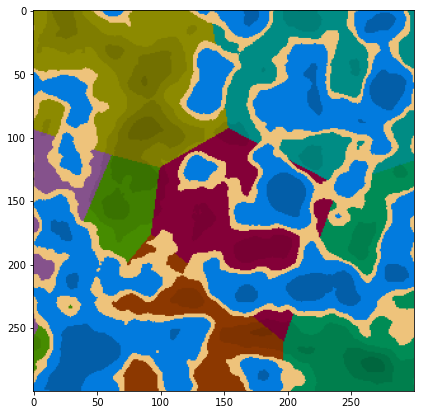

In [25]:
#for dynamically darkening and lightening colors of biomes.
def lerp_colors(a, b, t):
    return list(int(i + (j - i) * t) for i, j in zip(a, b))


biome_image = image.copy()

for y in range(height):
    for x in range(width):
        elev = elevations[y, x]
        ec = elevation_cutoff
        if elev < ec[0]:
            biome_image[y, x] = terrain_colors[0] #deepwater
        elif elev < ec[1]:
            biome_image[y, x] = terrain_colors[1] #shallow water
        elif elev < ec[2]:
            biome_image[y, x] = terrain_colors[2] #beach
        else: 
            b = biomes[y,x][0]
            if elev < ec[3]:
                color = lerp_colors(biome_colors[b], [0,0,0], 0.45)
                biome_image[y, x] = color #ground
            elif elev < ec[4]:
                color = lerp_colors(biome_colors[b], [0,0,0], 0.5)
                biome_image[y, x] = color #highground
            elif elev < ec[5]:
                color = lerp_colors(biome_colors[b], [0,0,0], 0.55)
                biome_image[y, x] = color #higherground
            else:
                color = lerp_colors(biome_colors[b], [0,0,0], 0.6)
                biome_image[y, x] = color #mountaintops

plt.figure(figsize = (7,7))
plt.imshow(biome_image)
plt.show()

Now, we can finally spread nations across the terrain:

In [26]:
plt.imshow(image)

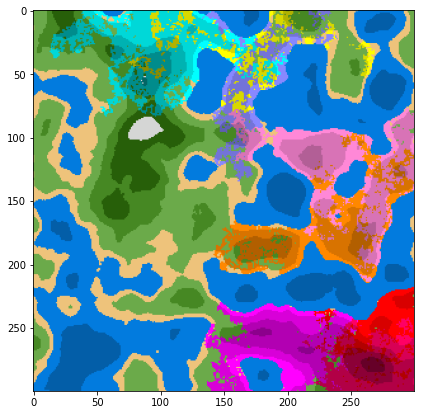

In [27]:
num_nations = 9
iterations = 20000
nation_colors = [[255, 255, 255], [255, 0, 0], [255, 0, 255], [0, 255, 255], [255, 0, 100], [255, 255, 0], [255, 136, 0], [136, 136, 255], [255, 136, 215]]

nations = []
nation_xs, nation_ys = nation_origins(width, height, is_water, num_nations)

for i in range(num_nations):
    nation = Nation(nation_xs[i], nation_ys[i], i, [0, 0, 0, 0, 0, 0, 0], 1, random.randint)
    nation.init_particles(30, 500)
    nations.append(nation)
    
nations_data = np.zeros((width, height))

nations_image = image.copy()


for i in range(iterations):
    for nation in nations:
        walk_particles_once(nation, width, height, elevations, is_water, biomes, nations_data)

for y in range(height):
    for x in range(width):
        elev = elevations[y, x]
        ec = elevation_cutoff
        
        nation = int(nations_data[y, x])
        
        if nation == 0:
            continue
        else:
            
            if elev < ec[2]:
                color = lerp_colors(nation_colors[nation], [0,0,0], 0.0)
                nations_image[y, x] = color #mountaintops
            elif elev < ec[3]:
                color = lerp_colors(nation_colors[nation], [0,0,0], 0.15)
                nations_image[y, x] = color #ground
            elif elev < ec[4]:
                color = lerp_colors(nation_colors[nation], [0,0,0], 0.3)
                nations_image[y, x] = color #highground
            elif elev < ec[5]:
                color = lerp_colors(nation_colors[nation], [0,0,0], 0.45)
                nations_image[y, x] = color #higherground
            else:
                color = lerp_colors(nation_colors[nation], [0,0,0], 0.6)
                nations_image[y, x] = color #mountaintops

plt.figure(figsize = (7,7))
plt.imshow(nations_image)
plt.show()

# Part V. Animating

### Note: This code was ran on a Ubuntu 22.04.01 LTS after installing ffmpeg with the apt package manager. I was unable to test it on other machines.

In [28]:
%matplotlib tk
#Setting up FFMpeg
from matplotlib.animation import FFMpegWriter


In [28]:
metadata = dict(title='Generic spread of nations. No bias.', artist='Sagit Bolat',comment='Generic Example')
writer = FFMpegWriter(fps=120, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)

############################################################################
iterations = 1000

nations = []
nation_xs, nation_ys = nation_origins(width, height, is_water, num_nations)

for i in range(num_nations):
    nation = Nation(nation_xs[i], nation_ys[i], i, [0, 0, 0, 0, 0, 0, 0], 1, random.randint)
    nation.init_particles(100, 100)
    nations.append(nation)
    
nations_data = np.zeros((width, height))

nations_image = image.copy()

#frames = [] #for the animation.

with writer.saving(fig,'project_2.mp4',dpi=200):
    for i in range(iterations):
        if i % 10 == 0: print(i)
        for nation in nations:
            walk_particles_once(nation, width, height, elevations, is_water, biomes, nations_data)
            for y in range(height):
                for x in range(width):
                    elev = elevations[y, x]
                    ec = elevation_cutoff

                    nation = int(nations_data[y, x])

                    if nation == 0:
                        continue
                    else:

                        if elev < ec[2]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.0)
                            nations_image[y, x] = color #mountaintops
                        elif elev < ec[3]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.15)
                            nations_image[y, x] = color #ground
                        elif elev < ec[4]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.3)
                            nations_image[y, x] = color #highground
                        elif elev < ec[5]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.45)
                            nations_image[y, x] = color #higherground
                        else:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.6)
                            nations_image[y, x] = color #mountaintops

        fig.clear()
        ax = fig.gca()
        plt.imshow(nations_image)
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()
        plt.pause(0.01)
        writer.grab_frame()

print("Done.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Done.


# Part VI. Tweaking values and creating variations.

Manually placing nations, then adjusting their bias to be exclusive to their biome

In [29]:
metadata = dict(title='Strong Biome Bias', artist='matplotlib',comment='Bias Example')
writer = FFMpegWriter(fps=60, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)

############################################################################
iterations = 2000

nations = []
nation_xs = [25, 150, 250, 85, 225, 90, 175, 225, 290]
nation_ys = [25, 250, 275, 100, 0,   20, 200, 125, 30]

for i in range(num_nations):
    biome_bias = [1000, 1000, 1000, 1000, 1000, 1000, 1000]
    x = nation_xs[i]
    y = nation_ys[i]
    biome_indx = int(biomes[y,x][0])
    biome_bias[biome_indx] = 0
    nation = Nation(x, y, i, biome_bias, 1, random.randint)
    nation.init_particles(100, 500)
    nations.append(nation)
    
nations_data = np.zeros((width, height))

nations_image = image.copy()

#frames = [] #for the animation.

with writer.saving(fig,'project_bias.mp4',dpi=200):
    for i in range(iterations):
        if i % 10 == 0: print(i)
        for nation in nations:
            walk_particles_once(nation, width, height, elevations, is_water, biomes, nations_data)
            for y in range(height):
                for x in range(width):
                    elev = elevations[y, x]
                    ec = elevation_cutoff

                    nation = int(nations_data[y, x])

                    if nation == 0:
                        continue
                    else:

                        if elev < ec[2]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.4)
                            nations_image[y, x] = color #mountaintops
                        elif elev < ec[3]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.45)
                            nations_image[y, x] = color #ground
                        elif elev < ec[4]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.5)
                            nations_image[y, x] = color #highground
                        elif elev < ec[5]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.55)
                            nations_image[y, x] = color #higherground
                        else:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.6)
                            nations_image[y, x] = color #mountaintops

        fig.clear()
        ax = fig.gca()
        plt.imshow(nations_image)
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()
        plt.pause(0.01)
        writer.grab_frame()

print("Done.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Done.


In [31]:
metadata = dict(title='Strong Biome Bias', artist='matplotlib',comment='Bias Example')
writer = FFMpegWriter(fps=60, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)

############################################################################
iterations = 2000

nations = []
nation_xs = [25, 150, 250, 85, 225, 90, 175, 225, 250]
nation_ys = [25, 250, 275, 100,  0, 20, 200, 125, 180]

def rand_1(a, b): #cant go north
    direction = random.randint(0, 2)
    return direction
def rand_2(a, b): #cant go south
    direction = random.randint(0, 2)
    if direction == 2: return 3
    else: return direction
def rand_3(a, b): #cant go east
    direction = random.randint(0, 2)
    if direction == 1: return 3
    else: return direction
def rand_4(a, b): #cant go west
    direction = random.randint(0, 2)
    if direction == 0: return 3
    else: return direction
def rand_5(a, b): #tends to go east or west
    n = random.randint(0, 100)
    if n < 10: return 3
    elif n < 20: return 2
    elif n < 60: return 1
    else: return 0
def rand_6(a, b): #tends to go north or south
    n = random.randint(0, 100)
    if n < 10: return 0
    elif n < 20: return 1
    elif n < 60: return 2
    else: return 3

    
rand_functions = [rand_1, rand_2, rand_3, rand_4, rand_1, rand_5, rand_6, rand_5, rand_6]

for i in range(num_nations):
    biome_bias = [5, 5, 5, 5, 5, 5, 5]
    x = nation_xs[i]
    y = nation_ys[i]
    biome_indx = int(biomes[y,x][0])
    biome_bias[biome_indx] = 0
    
    
    nation = Nation(x, y, i, biome_bias, 1, rand_functions[i])
    nation.init_particles(100, 2000)
    nations.append(nation)
    
nations_data = np.zeros((width, height))

nations_image = image.copy()

#frames = [] #for the animation.

with writer.saving(fig,'project_spread_heuristic.mp4',dpi=200):
    for i in range(iterations):
        if i % 10 == 0: print(i)
        for nation in nations:
            walk_particles_once(nation, width, height, elevations, is_water, biomes, nations_data)
            for y in range(height):
                for x in range(width):
                    elev = elevations[y, x]
                    ec = elevation_cutoff

                    nation = int(nations_data[y, x])

                    if nation == 0:
                        continue
                    else:

                        if elev < ec[2]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.4)
                            nations_image[y, x] = color #mountaintops
                        elif elev < ec[3]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.45)
                            nations_image[y, x] = color #ground
                        elif elev < ec[4]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.5)
                            nations_image[y, x] = color #highground
                        elif elev < ec[5]:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.55)
                            nations_image[y, x] = color #higherground
                        else:
                            color = lerp_colors(nation_colors[nation], [0,0,0], 0.6)
                            nations_image[y, x] = color #mountaintops

        fig.clear()
        ax = fig.gca()
        plt.imshow(nations_image)
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()
        plt.pause(0.01)
        writer.grab_frame()

print("Done.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Done.
